In [1]:
# k crossover d，close > ema 8, ema 8 > ema 18, ema 18 > 38, take profit atr, stop loss atr
# Variables :
# time - 15m, 1h
# start time - 1609492611000, 1641028611000, 1672564611000 (2021, 2022, 2023)
# tp atr - 4, 6
# sl atr - 3, 5
# sl - Close, Low

In [2]:
# ! conda install -c conda-forge ta --yes

In [3]:
import requests
import pandas as pd
import ta
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import time

In [4]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '1h'

# start epoch till now
start_time = 1672564611000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [5]:
sl_atr = 3
tp_atr = 10
kd_dir = 'Any'

In [6]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    rawdf = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        rawdf = pd.concat([rawdf, out], axis = 0)
    
    rawdf = rawdf[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    rawdf = rawdf.astype(convert_dict)
    
    rawdf['Close_Time'] = pd.to_datetime(rawdf['Close_Time'], unit = 'ms')
    rawdf['Close_Time'] = rawdf['Close_Time'] + pd.Timedelta(hours=timezone)
    rawdf['Close_Time'] = rawdf['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    rawdf = rawdf.reset_index(drop=True)
    
    return rawdf

In [7]:
rawdf = get_historical(symbol, interval, start_time, end_time, step)
print(rawdf)

               Close_Time     Open    Close     High      Low      Volume
0     2023-01-01 18:59:59  1196.47  1197.14  1197.19  1195.59   2006.5809
1     2023-01-01 19:59:59  1197.14  1196.34  1197.41  1195.72   2854.0542
2     2023-01-01 20:59:59  1196.35  1197.17  1198.50  1195.83   4418.7365
3     2023-01-01 21:59:59  1197.16  1195.26  1197.29  1193.54   4804.4490
4     2023-01-01 22:59:59  1195.26  1194.50  1195.86  1194.20   3496.2584
...                   ...      ...      ...      ...      ...         ...
3526  2023-05-28 17:59:59  1845.43  1844.87  1846.60  1843.76   3121.1463
3527  2023-05-28 18:59:59  1844.88  1845.80  1846.72  1843.21   5307.2585
3528  2023-05-28 19:59:59  1845.80  1843.50  1851.79  1843.21  10735.6968
3529  2023-05-28 20:59:59  1843.51  1840.60  1844.42  1837.17   8891.4934
3530  2023-05-28 21:59:59  1840.60  1841.39  1841.40  1840.59    705.3128

[3531 rows x 6 columns]


In [8]:
df = rawdf.copy()

In [9]:
def check_cross(df, kd_dir):
    up = df['slow_k'] > df['slow_d']
    down = df['slow_k'] < df['slow_d']
    if kd_dir == 'Up':
        return up.diff() & up
    if kd_dir == 'Any':
        return up.diff()
    if kd_dir == 'Down':
        return down.diff() & down


def indicators(df, kd_dir):

# ema
    for i in (8, 18, 38):
        df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)

# bband
#     bb_int = 30
#     bb_dev = 2
#     bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
#     df['bb_u'] = bb.bollinger_hband()
#     df['bb_m'] = bb.bollinger_mavg()
#     df['bb_l'] = bb.bollinger_lband()        
        
# atr
    df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)
    
# rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()

# kd
    kd_int = 14
    d_int = 3
   
    kd_df = pd.DataFrame()
    kd_df[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kd_df[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slow_k'] = (df['Close'] - kd_df[str(kd_int) + '-Low'])*100/(kd_df[str(kd_int) + '-High'] - kd_df[str(kd_int) + '-Low'])
    df['slow_d'] = df['slow_k'].rolling(d_int).mean()
    
# kd cross
    df['kd_cross'] = check_cross(df, kd_dir)

In [10]:
indicators(df, kd_dir)
# indicators(df)

In [11]:
def conditions(df):
    # k crossover d，close > ema 8, ema 8 > ema 14, ema 14 > 50, take profit 2 atr, stop loss 3 atr

    for index, row in df.iterrows():
        # c1
        df['c1'] = df['kd_cross']
        # c2
        df['c2'] = df['ema_8'] >= df['ema_18']
        # c3
        df['c3'] = df['ema_18'] >= df['ema_38']
        
        df['c4'] = df['Low'] <= df['ema_38']
        


    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3 & df.c4, 'signal'] = True


    # 下一根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
#     print(df[df['Close_Time'].str.contains('2023-03-11 16')])
    
    return df

In [12]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,ema_8,ema_18,ema_38,atr,rsi,slow_k,slow_d,kd_cross,c1,c2,c3,c4,signal,openbuy
0,2023-01-01 18:59:59,1196.47,1197.14,1197.19,1195.59,2006.5809,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
1,2023-01-01 19:59:59,1197.14,1196.34,1197.41,1195.72,2854.0542,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
2,2023-01-01 20:59:59,1196.35,1197.17,1198.50,1195.83,4418.7365,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
3,2023-01-01 21:59:59,1197.16,1195.26,1197.29,1193.54,4804.4490,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
4,2023-01-01 22:59:59,1195.26,1194.50,1195.86,1194.20,3496.2584,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3526,2023-05-28 17:59:59,1845.43,1844.87,1846.60,1843.76,3121.1463,1845.094042,1840.406826,1833.648008,6.776603,61.466620,59.247911,64.072099,False,False,True,True,False,False,False
3527,2023-05-28 18:59:59,1844.88,1845.80,1846.72,1843.21,5307.2585,1845.250921,1840.974528,1834.271187,6.543274,62.484749,61.838440,61.321780,True,True,True,True,False,False,False
3528,2023-05-28 19:59:59,1845.80,1843.50,1851.79,1843.21,10735.6968,1844.861828,1841.240367,1834.744460,6.688755,58.376707,55.431755,58.839369,True,True,True,True,False,False,False
3529,2023-05-28 20:59:59,1843.51,1840.60,1844.42,1837.17,8891.4934,1843.914755,1841.172960,1835.044744,6.728844,53.592402,47.353760,54.874652,False,False,True,True,False,False,False


In [13]:
entry_df = conditions(df).copy()

in_position = False
stop_loss = np.nan
take_profit = np.nan
close_val = entry_df['Close']
atr_val = entry_df['atr']


for index, row in entry_df.iterrows():

    if index == 0:
        continue
    
    elif entry_df.at[index, 'openbuy'] == True:
   
        entry_df.at[index, 'entry_p'] = close_val.shift(1).at[index]
        entry_df.at[index, 'stop_loss'] = close_val.shift(1).at[index] - sl_atr * atr_val.shift(1).at[index]
        entry_df.at[index, 'take_profit'] = close_val.shift(1).at[index] + tp_atr * atr_val.shift(1).at[index]
        entry_df.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = entry_df.at[index, 'stop_loss']
        take_profit = entry_df.at[index, 'take_profit']
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and (entry_df.at[index, 'Close'] <= stop_loss):
        entry_df.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan

    # set take profit
    elif in_position == True and (entry_df.at[index, 'High'] >= take_profit):
        entry_df.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan
        
entry_df.to_csv('entry_df.csv')
        
raw_entry_df = entry_df.copy()

# 過濾有訊號或事件發生的Ｋ線
entry_df = entry_df[(entry_df['openbuy'] == True) |
              (entry_df['signal'] == True) | 
              (entry_df['position'] == 'Buy') |
              (entry_df['position'] == 'Sell') |
              (entry_df['position'] == 'Stop')]

print(entry_df)

               Close_Time     Open    Close     High      Low      Volume  \
174   2023-01-09 00:59:59  1274.25  1264.02  1280.00  1261.91  24913.8017   
175   2023-01-09 01:59:59  1264.02  1264.60  1268.01  1263.08   8796.1189   
184   2023-01-09 10:59:59  1294.03  1306.16  1312.50  1291.39  60447.4448   
236   2023-01-11 14:59:59  1330.87  1333.51  1333.88  1327.19  16196.4637   
237   2023-01-11 15:59:59  1333.51  1335.52  1335.70  1332.73   9480.8077   
...                   ...      ...      ...      ...      ...         ...   
3476  2023-05-26 15:59:59  1811.62  1816.71  1817.72  1809.52  11104.1324   
3504  2023-05-27 19:59:59  1826.54  1826.83  1828.36  1822.45   5291.3805   
3505  2023-05-27 20:59:59  1826.83  1828.18  1830.40  1824.76   4491.4213   
3517  2023-05-28 08:59:59  1829.89  1849.07  1854.90  1823.60  28565.1095   
3518  2023-05-28 09:59:59  1849.08  1848.78  1859.50  1847.00  26580.5389   

            ema_8       ema_18       ema_38       atr  ...     c1    c2    

In [14]:
# 部位回測

pos_df = entry_df.copy()
pos_df = pos_df.reset_index(drop = True)
pos_df = pos_df[(pos_df['position'] == 'Buy') |
              (pos_df['position'] == 'Sell') |
              (pos_df['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'ema_8', 'ema_18', 'ema_38', 'rsi', 'position','entry_p', 'stop_loss', 'take_profit']
pos = pos_df[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：達成條件時收盤價
        if pos.at[index, 'position'] == 'Sell':
#             pos.at[index, 'exit_p'] = pos.at[index, 'Close']
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'take_profit']
                break

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            pos.at[index, 'exit_p'] = pos.at[index, 'Open']
#             for i in range(index -1, -1, -1):
#                 if pos.at[i, 'position'] == 'Buy':
#                     pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
#                 break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break


# 手續費、滑點、價差
fee = 0.05 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee


# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算獲利/虧損次數
agg_amts = []

for i in range(len(pos) - 1, -1, -1):

    if pos.loc[i, 'position'] in ['Stop', 'Sell']:
        
        # look out for the + sign
        total_amt = pos.loc[i, 'amt'] + np.absolute(pos.loc[i, 'amt']) * fee
        
        # iterate backwards from the current row until reaching another 'Stop' or 'Sell'
        # watch out for the + in total_amt += trading_fee
        j = i - 1
        while j >= 0 and pos.loc[j, 'position'] not in ['Stop', 'Sell']:
            total_amt += pos.loc[j, 'amt']
            trading_fee = np.absolute(pos.loc[j, 'amt']) * fee
            total_amt += trading_fee
            j -= 1
        
        # add the aggregated amount to the list
        agg_amts.append(total_amt)

agg_amts.reverse()


# 計算進場最大部位，最大損益
consec_entry = 0
position_amt_sum = 0
max_consec_entry = 0
max_position = 0
max_profit = 0
max_loss = 0

for index, row in pos.iterrows():
    
    if row['position'] == 'Buy':
        
        consec_entry += 1
        position_amt_sum += row['amt']
        
    elif row['position'] in ['Sell', 'Stop']:
        
        if consec_entry > max_consec_entry:
            max_consec_entry = consec_entry
            max_position = position_amt_sum
            
        position_amt_sum += row['amt']
        
        if -position_amt_sum > max_profit:
            max_profit = -position_amt_sum
            
        if -position_amt_sum < max_loss:
            max_loss = -position_amt_sum
            
        consec_entry = 0
        position_amt_sum = 0
    
    else:
        pass

# 最大部位
profit_per = "{:.2f}%".format(ttl_profit / (max_position/leverage) * 100)


# 勝率
wins = 0
loses = 0

for trade in agg_amts:
    if trade < 0:
        wins += 1
    elif trade > 0:
        loses += 1

win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)


# 結果
result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Profit': [round(max_profit, 2)],
          'Max_Loss': [round(max_loss, 2)],
          'Max_Entry': [max_consec_entry],
          'Max_Position': [round(max_position, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)
print()
print(pos)

pos.to_csv('pos.csv')


   Profit     Fee  Max_Profit  Max_Loss  Max_Entry  Max_Position Profit_%  \
0 -360.62  148.31      230.72   -105.61          9      16268.62  -22.17%   

  Win_Rate  
0   29.63%  

              Close_Time     Open    Close     High      Low        ema_8  \
0    2023-01-09 01:59:59  1264.02  1264.60  1268.01  1263.08  1265.351845   
1    2023-01-09 10:59:59  1294.03  1306.16  1312.50  1291.39  1286.817493   
2    2023-01-11 15:59:59  1333.51  1335.52  1335.70  1332.73  1333.606230   
3    2023-01-12 08:59:59  1389.40  1415.23  1418.77  1386.00  1365.165144   
4    2023-01-12 22:59:59  1405.14  1381.00  1407.98  1372.42  1395.214185   
..                   ...      ...      ...      ...      ...          ...   
107  2023-05-20 12:59:59  1813.43  1813.40  1813.94  1811.55  1811.864640   
108  2023-05-20 14:59:59  1810.59  1809.92  1811.02  1808.41  1811.213918   
109  2023-05-20 16:59:59  1811.18  1814.55  1814.78  1811.18  1811.951135   
110  2023-05-22 22:59:59  1822.09  1819.35  1824

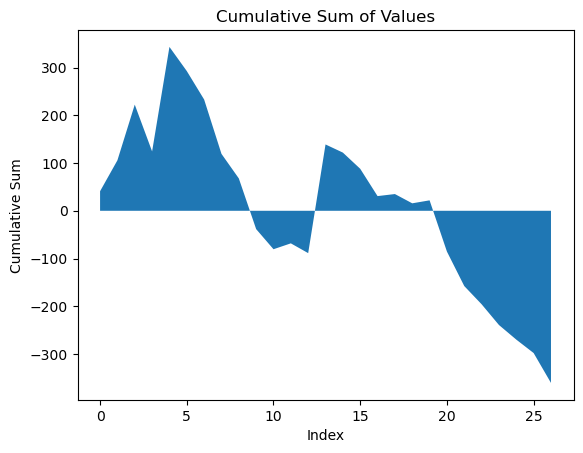

[40.92967260000004, 105.7116883000001, 222.38976715000015, 124.3453471500005, 343.2891785500009, 292.7268735500005, 233.10484355000105, 119.24663855000057, 67.81885855000047, -38.41279144999922, -80.53538644999941, -68.22373144999948, -88.71837644999923, 138.96782210000066, 121.89098210000039, 87.99216210000023, 30.763347100000928, 35.05892710000052, 15.64081710000034, 21.872977100000526, -85.45215289999992, -157.69981290000095, -195.84899790000068, -239.2885929000007, -269.90003790000134, -298.0318079000015, -360.6237829000014]


In [15]:
cumulative_values = []
cumulative_sum = 0
for value in agg_amts:
    cumulative_sum -= value
    cumulative_values.append(cumulative_sum)

plt.fill_between(range(len(cumulative_values)), cumulative_values, 0)

plt.xlabel('Index')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum of Values')

plt.show()

print(cumulative_values)

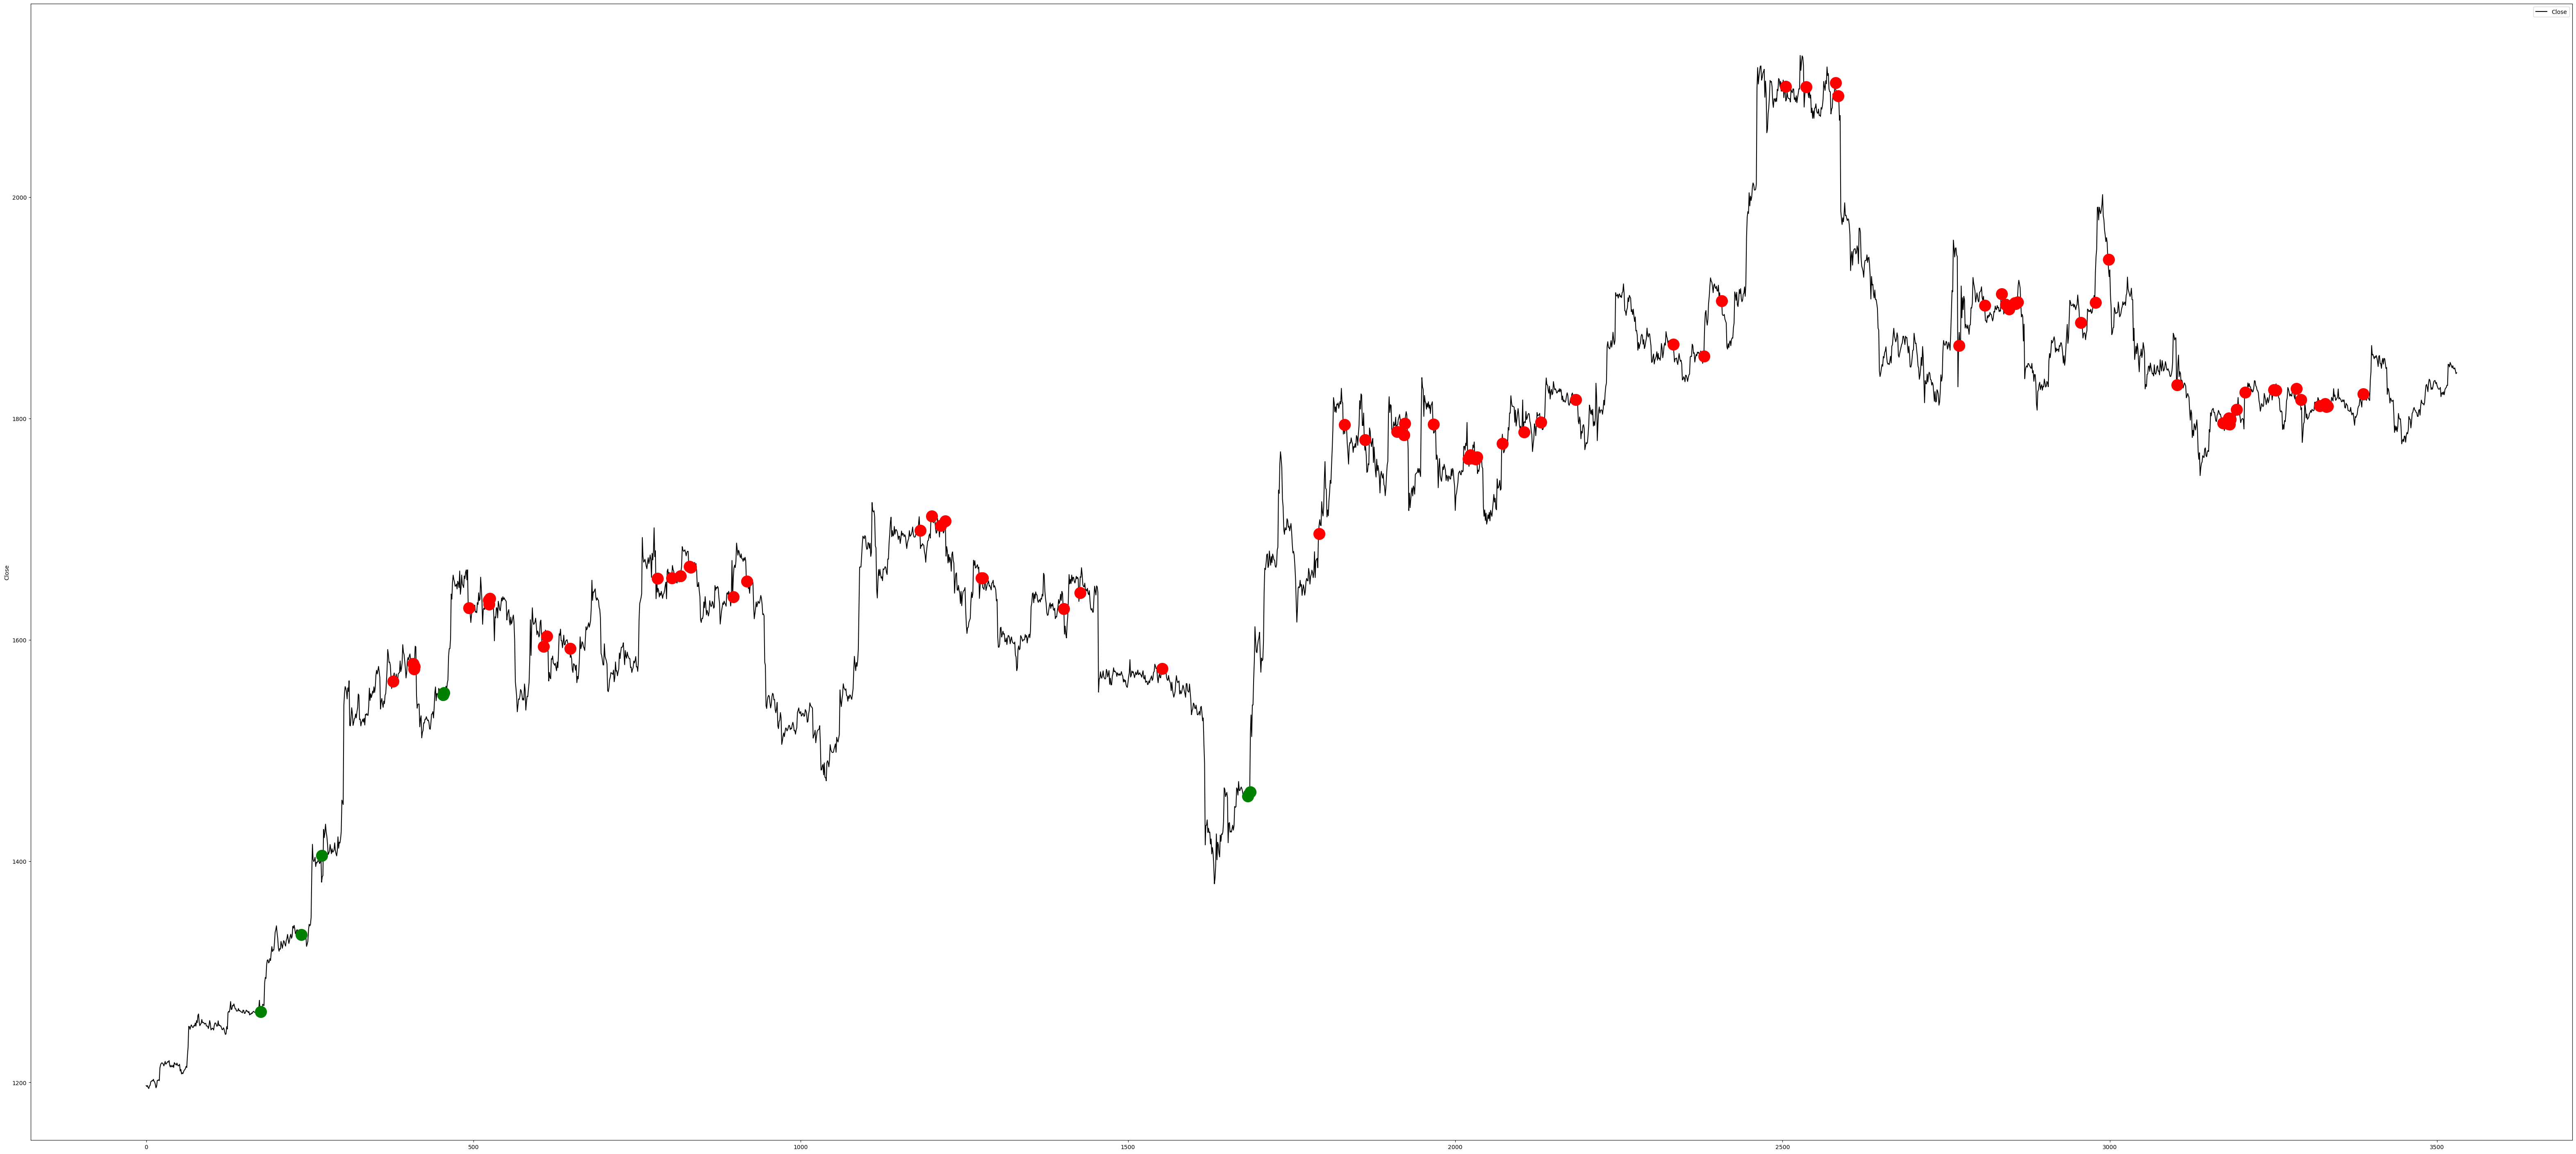

In [16]:
plt_df = raw_entry_df.copy()

plt.figure(figsize=(80, 36))
plt.ylabel('Close')
plt.plot(plt_df.Close, label = 'Close', c ='black')

i = 0
while i < len(plt_df):
    if pd.isna(plt_df.position[i]):
        i += 1
    elif plt_df.position[i] == 'Buy':
        j = i + 1
        while j < len(plt_df) and (pd.isna(plt_df.position[j]) or plt_df.position[j] == 'Buy'):
            j += 1
        if j < len(plt_df) and plt_df.position[j] == 'Sell':
            # Paint all previous 'Buy's green dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'go', label='_', markersize=20)
            i = j
        elif j < len(plt_df) and plt_df.position[j] == 'Stop':
            # Paint all previous 'Buy's red dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'ro', label='_', markersize=20)
            i = j + 1
        else:
            i = j
    else:
        i += 1

plt.legend()
plt.show()


# 之所以出現大量紅點，原因為：連續加倉會調整整個部位停利和停損，因此一些進倉部位會因為調高後的＂整個部位＂停損而出場，但該入場損益依舊為正
# 意思是該部位之停損已經高於許多前面部位之進場點位